In [1]:
import numpy as np
import random
from os import listdir
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

2025-06-16 19:24:23.960097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750101864.144095      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750101864.199333      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def create_dataset_from_directory(
    directory: str,
    img_size: tuple = (224, 224),
    batch_size: int = 16,
    seed: int = 42,
    validation_split: float = 0.2
):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=validation_split
    )

    train_generator = datagen.flow_from_directory(
        directory=directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True,
        seed=seed
    )

    val_generator = datagen.flow_from_directory(
        directory=directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=False
    )

    return train_generator, val_generator

In [3]:
def plot_class_distribution(generator):
    labels = generator.classes
    class_names = list(generator.class_indices.keys())
    counts = Counter(labels)

    sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels, sorted_counts = zip(*sorted_items)
    sorted_class_names = [class_names[i] for i in sorted_labels]

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_class_names, sorted_counts, color="salmon")
    plt.title("Distribución por clase (Train)")
    plt.xlabel("Cantidad de imágenes")
    plt.ylabel("Clase")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [4]:
def plot_sample_images(generator, n=8):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        label_idx = int(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
train_dataset, val_dataset = create_dataset_from_directory(
    directory="/kaggle/input/multi-class-driver-behavior-image-dataset/Multi-Class Driver Behavior Image Dataset"
)

Found 5824 images belonging to 5 classes.
Found 1452 images belonging to 5 classes.


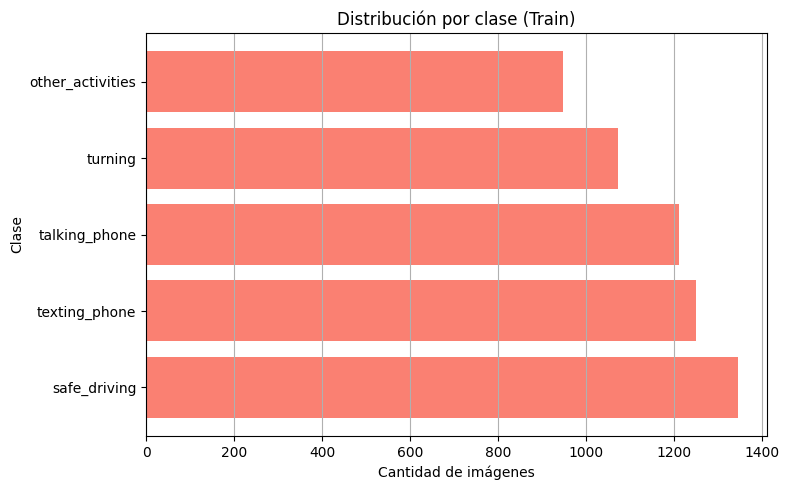

In [6]:
plot_class_distribution(train_dataset)

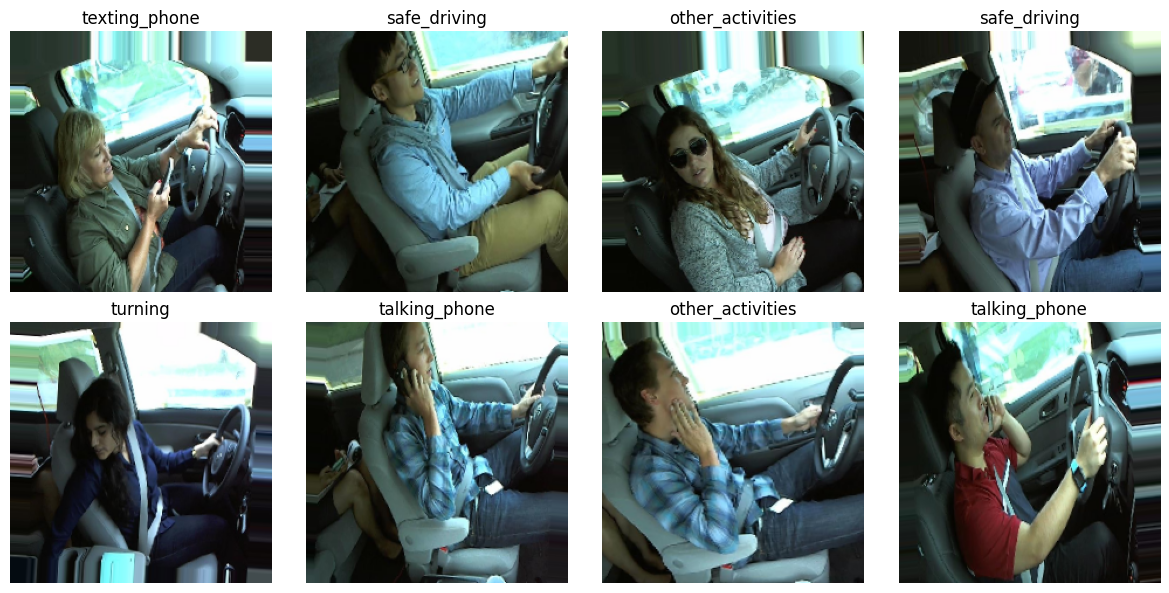

In [7]:
plot_sample_images(train_dataset)

In [8]:
def create_model(input_shape=(224, 224, 3), num_classes=5):
    model = models.Sequential([
        # Bloque 1: Conv(32) → Conv(32) → Pool
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),

        # Bloque 2: Conv(64) → Conv(64) → Pool
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        # Transición a denso: GAP → Dense(128) → Output
        layers.Flatten(),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)), # Ajustar L2
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [9]:
model = create_model(
    input_shape=(224, 224, 3),
    num_classes=train_dataset.num_classes
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750101885.645604      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [12]:
# Calcular los pesos de clase
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_dataset.classes), y=train_dataset.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=2,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1750101892.208701      75 service.cc:148] XLA service 0x7a61840065a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750101892.209620      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750101892.724521      75 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750101899.438600      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


364/364 - 200s - 550ms/step - accuracy: 0.3793 - loss: 5.9622 - val_accuracy: 0.2307 - val_loss: 10.2916 - learning_rate: 5.0000e-04
Epoch 2/40
364/364 - 134s - 367ms/step - accuracy: 0.4797 - loss: 4.6635 - val_accuracy: 0.3898 - val_loss: 7.8374 - learning_rate: 5.0000e-04
Epoch 3/40
364/364 - 135s - 371ms/step - accuracy: 0.5328 - loss: 5.5701 - val_accuracy: 0.3726 - val_loss: 6.0694 - learning_rate: 5.0000e-04
Epoch 4/40
364/364 - 132s - 362ms/step - accuracy: 0.5948 - loss: 5.5740 - val_accuracy: 0.3223 - val_loss: 14.2407 - learning_rate: 5.0000e-04
Epoch 5/40
364/364 - 132s - 362ms/step - accuracy: 0.5982 - loss: 5.3011 - val_accuracy: 0.3760 - val_loss: 10.7530 - learning_rate: 5.0000e-04
Epoch 6/40

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
364/364 - 135s - 372ms/step - accuracy: 0.5713 - loss: 6.8264 - val_accuracy: 0.4552 - val_loss: 6.5410 - learning_rate: 5.0000e-04
Epoch 7/40
364/364 - 132s - 363ms/step - accuracy: 0.6963 - loss: 4.3180 

In [14]:
def plot_history(history):
    """
    Grafica la precisión y la pérdida de entrenamiento y validación a lo largo de las épocas.
    """
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión por Época')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida por Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
def plot_confusion_matrix(model, val_dataset):
    """
    Imprime el reporte de clasificación y grafica la matriz de confusión.
    """
    # Obtener etiquetas verdaderas desde el generador
    y_true = val_dataset.classes

    # Obtener predicciones
    y_pred_probs = model.predict(val_dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Nombres de clases
    clases = list(val_dataset.class_indices.keys())

    # Reporte y matriz de confusión
    print(classification_report(y_true, y_pred, target_names=clases, zero_division=0))

    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        display_labels=clases,
        ax=ax,
        cmap='Blues',
        xticks_rotation=45
    )
    plt.title("Matriz de Confusión - Validación")
    plt.tight_layout()
    plt.show()

In [16]:
def mostrar_predicciones_batch(model, dataset, num_imagenes=12):
    import random

    class_names = list(dataset.class_indices.keys())

    # Tomar un solo batch aleatorio del generador
    total_batches = len(dataset)
    batch_idx = random.randint(0, total_batches - 1)
    images, labels = dataset[batch_idx]

    y_pred = np.argmax(model.predict(images, verbose=0), axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_imagenes, len(images))):
        img = images[i]
        true = int(labels[i])
        pred = int(y_pred[i])
        correcto = pred == true

        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        color = "green" if correcto else "red"
        plt.title(
            f"Real: {class_names[true]}\nPred: {class_names[pred]}",
            color=color,
            fontsize=9
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [17]:
def resumen_metricas(model, dataset):
    y_true = dataset.classes
    y_pred = np.argmax(model.predict(dataset, verbose=0), axis=1)

    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision macro:", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall macro:", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1-score macro:", f1_score(y_true, y_pred, average='macro', zero_division=0))

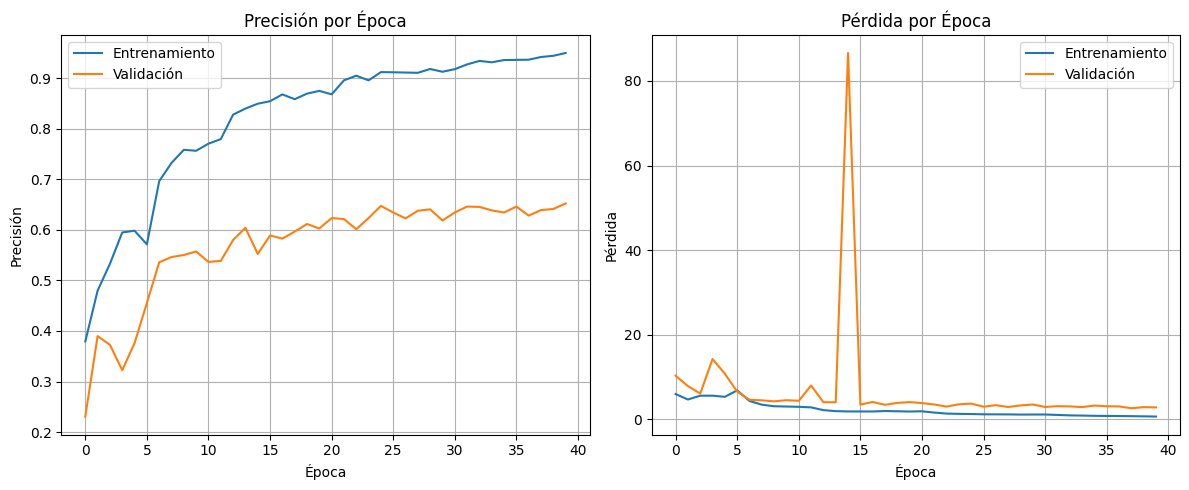

In [18]:
plot_history(history)

                  precision    recall  f1-score   support

other_activities       0.36      0.33      0.34       236
    safe_driving       0.56      0.74      0.63       335
   talking_phone       0.81      0.73      0.77       302
   texting_phone       0.72      0.82      0.77       312
         turning       0.75      0.47      0.58       267

        accuracy                           0.64      1452
       macro avg       0.64      0.62      0.62      1452
    weighted avg       0.65      0.64      0.63      1452



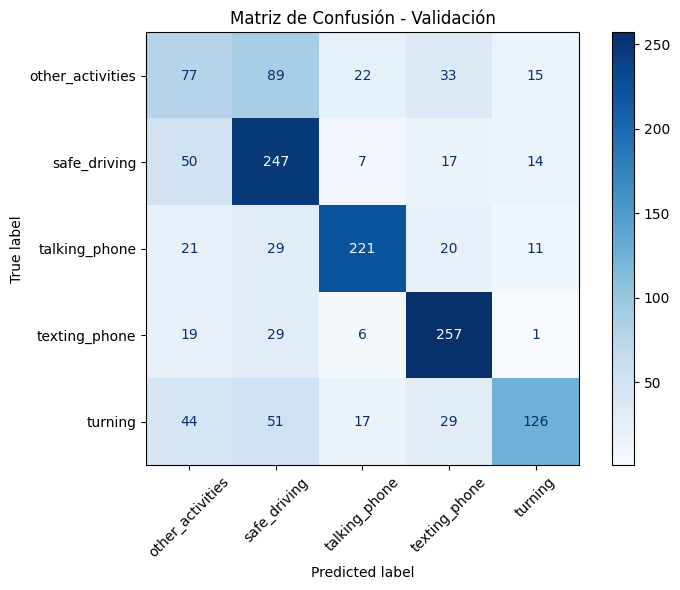

In [19]:
plot_confusion_matrix(model, val_dataset)

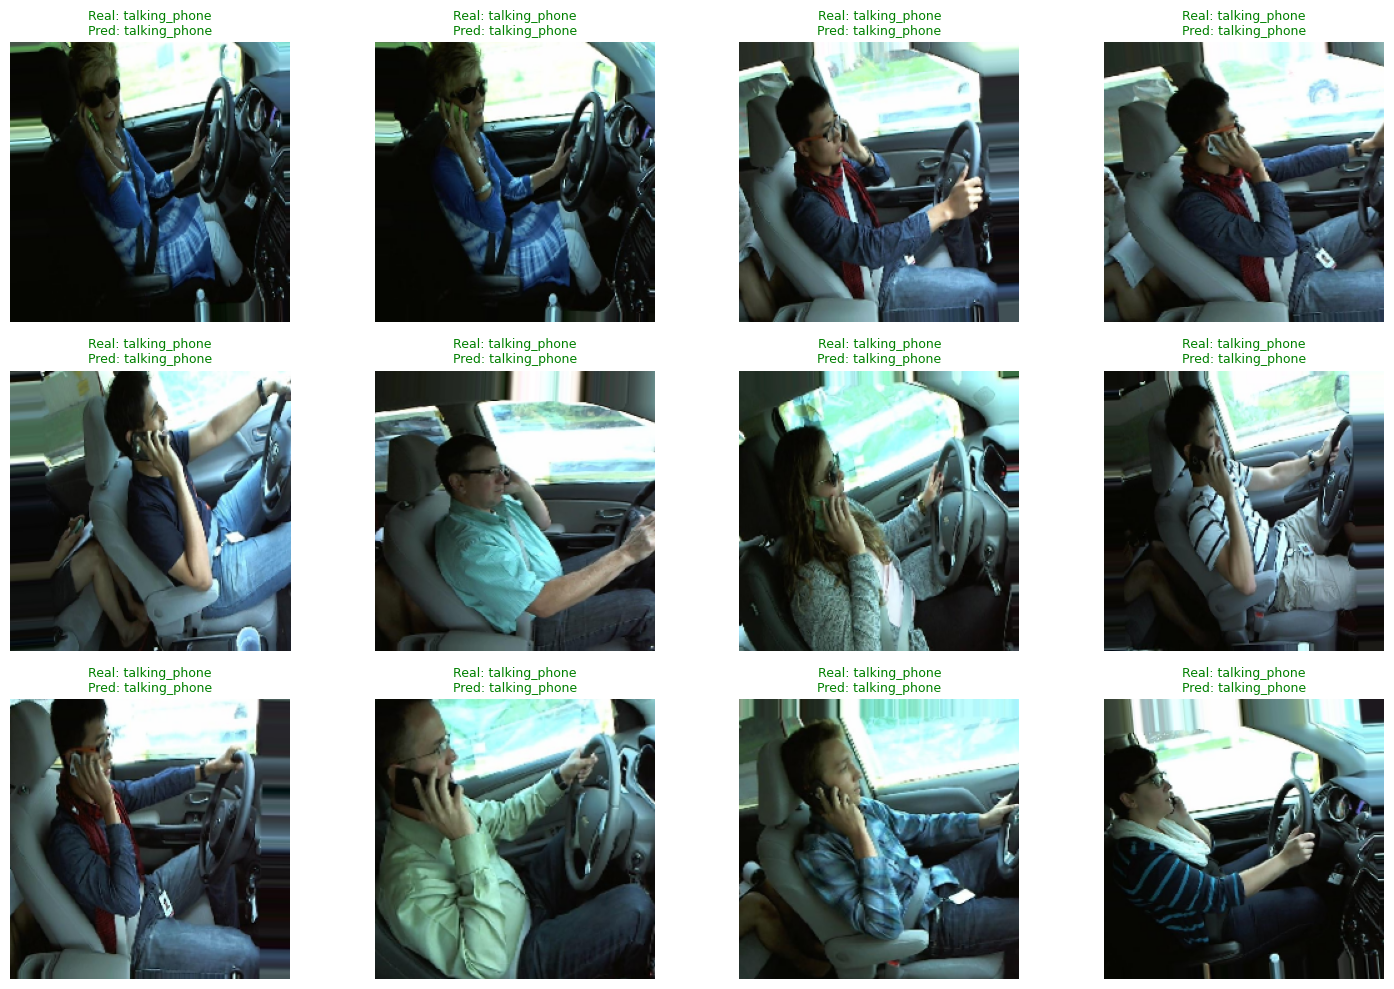

In [20]:
mostrar_predicciones_batch(model, val_dataset)

In [21]:
resumen_metricas(model, val_dataset)

Accuracy: 0.6473829201101928
Precision macro: 0.6545599274261444
Recall macro: 0.6262374804028615
F1-score macro: 0.6273596043988693
